In [1]:
!pip install gdown

In [2]:
!gdown 1OZoqCUo48iXDPfD71uq0olbzkdnixvrE

Downloading...
From (original): https://drive.google.com/uc?id=1OZoqCUo48iXDPfD71uq0olbzkdnixvrE
From (redirected): https://drive.google.com/uc?id=1OZoqCUo48iXDPfD71uq0olbzkdnixvrE&confirm=t&uuid=331f8a3c-bb42-4b94-9654-e0d509b29add
To: /content/LibriSpeech_WAV.zip
100% 10.5G/10.5G [02:01<00:00, 86.1MB/s]


In [3]:
!unzip LibriSpeech_WAV.zip

Streaming output truncated to the last 5000 lines.
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0008.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0029.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0003.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0019.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0000.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0012.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0020.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0014.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0011.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0022.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0028.wav  
  inflating: LibriSpeech_WAV/train-clean/7517/100442/7517-100442-0006.wav  
  inflating: LibriSpeech_WAV/train-cl

In [4]:
!pip install librosa matplotlib pandas numpy scipy tqdm soundfile

# Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft
from tqdm import tqdm

# EDA

## Train-Clean Data

In [6]:
# load all .wav paths from LibriSpeech

DATASET_PATH_1 = "LibriSpeech_WAV/train-clean"

wav_files_train = []
for root, _, files in os.walk(DATASET_PATH_1):
    for f in files:
        if f.endswith(".wav"):
            wav_files_train.append(os.path.join(root, f))

print("Total wav files:", len(wav_files_train))

Total wav files: 28539


In [7]:
# Basic Metadata EDA (sample rate, duration, size)
metadata = []

for path in tqdm(wav_files_train[:1000]):
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    size_kb = os.path.getsize(path) / 1024

    metadata.append([path, sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["path", "sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 1000/1000 [00:27<00:00, 36.83it/s]


,path,sample_rate,duration_sec,size_kb
0,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,6.190,193.480469
1,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,10.850,339.105469
2,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,15.905,497.074219
3,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,14.715,459.886719
4,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,5.440,170.042969
5,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,12.555,392.386719
6,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,6.255,195.511719
7,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,10.605,331.449219
8,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,14.835,463.636719
9,LibriSpeech_WAV/train-clean/5703/47212/5703-47...,16000,9.550,298.480469


- The sample rate is uniformly 16000 Hz, which is the standard for speech recognition task. This indicates that resampling is likely not needed for preprocessing.
- The duration varies, which means data loader will need to handle variable-length sequences, likely via padding (to the longest batch length) or masking.
- File size strictly correlates with duration

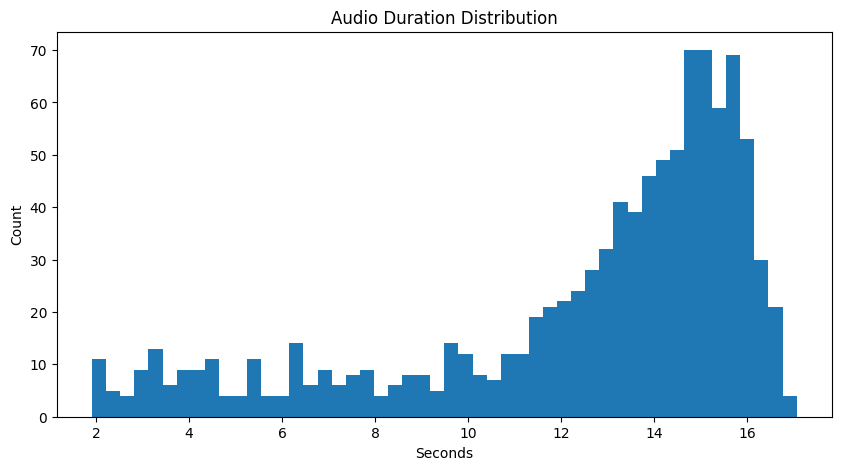

In [8]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- Minimum duration seems to be no shorter than 2 seconds. This seems good, as extremely short clips often contain only silence or cut-off words, which can destabilize training.
- Maximum duration seems to be capped around 17 seconds. This "hard stop" suggests the dataset was pre-segmented to avoid extremely long utterances.
- The audio distribution is left skewed with a heavy concentration of files between 12 to 16 seconds. Might consider padding

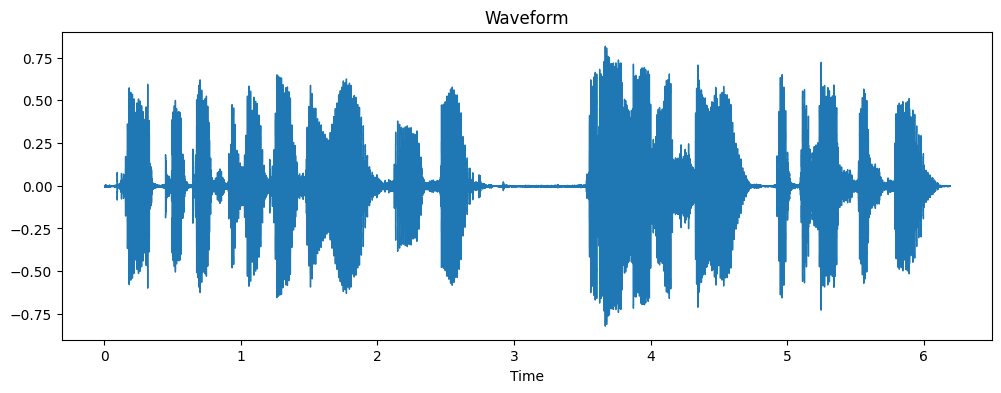

In [9]:
# Waveform Visualization (time domain)

sample_path = wav_files_train[0]
y, sr = librosa.load(sample_path, sr=None)

plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

- In the silence regions (start, end, and between words), the amplitude line is very thin and close to zero. This confirms the dataset is indeed "clean" speech with very little background noise. It has good Signal-To-Noise Ratio (SNR)
- The "blobs" of high amplitude represent words or phrases. There are distinct gaps between them, indicating clear sentence structures.
- The amplitude peaks reach roughly +/- 0.2. The audio is not "clipped" (hitting the +/- 1.0 maximum), which means the audio fidelity is preserved and no information is lost to distortion.

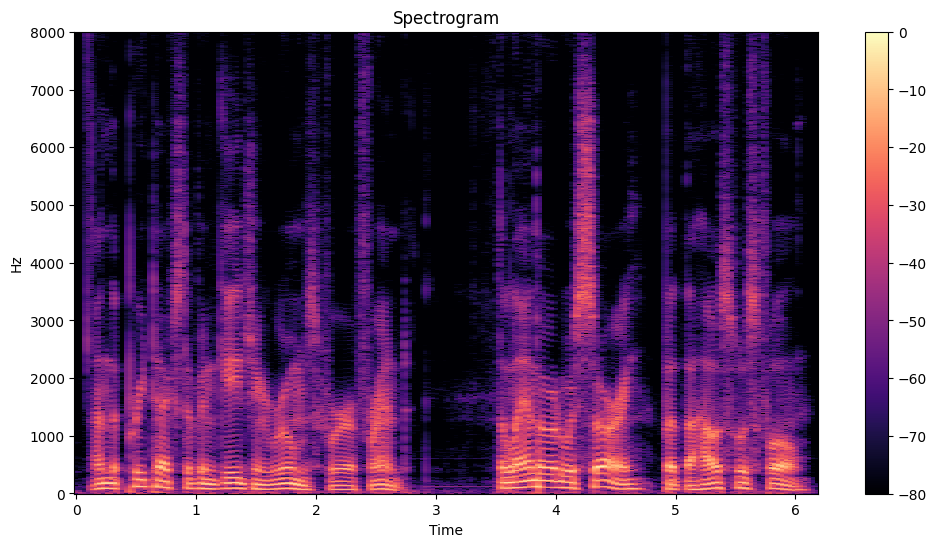

In [10]:
# Short-Time Fourier Transform (STFT) Spectogram
# To visualize signal frequency changes over time

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()

- The y-axis goes up to 8000 Hz. This is mathematically consistent with the 16 kHz sample rate (Nyquist frequency = Sample Rate / 2).
- Most of the energy (bright orange/yellow) is concentrated between 0 and 4000 Hz. This is typical for human speech.
- The horizontal "striations" in the lower frequencies, represent the harmonics of the speaker's vocal cords (voiced speech).
- The shifting bright bands represent formants, which are critical for distinguishing vowel sounds.
- The deep purple/black background confirms the high SNR observed in the waveform. There is almost no constant background hum or static.

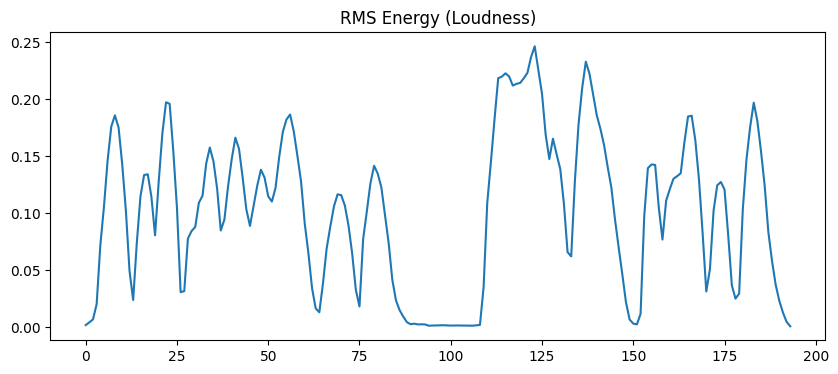

In [11]:
# Amplitude / Loudness (RMS)

rms = librosa.feature.rms(y=y)[0]

plt.figure(figsize=(10,4))
plt.plot(rms)
plt.title("RMS Energy (Loudness)")
plt.show()

- The plot clearly shows high energy peaks (active speech) and near-zero valleys (silence).
- The peaks vary in height, indicating natural speech dynamics (some words are stressed/louder than others).
- This feature is excellent for segmenting audio. We could use a simple threshold on this graph to automatically crop silence from the start/end of clips, reducing the data size without losing information.

100%|██████████| 200/200 [00:00<00:00, 697.59it/s]


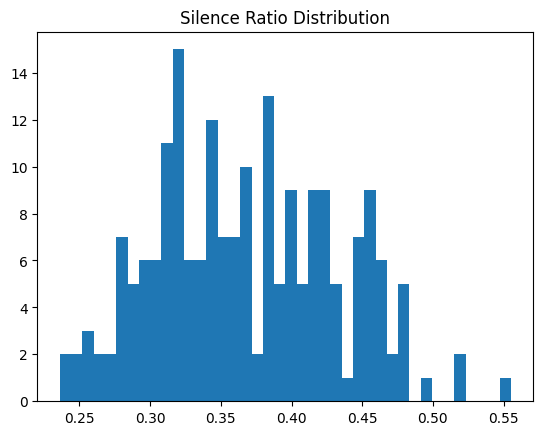

In [12]:
# Silence ratio

def silence_ratio(y, threshold=0.01):
    """
    Input: y is the audio waveform array, threshold defines what amplitude is treated as silence.
    Process: Counts how many samples in y have absolute amplitude below the threshold.
    Output: Returns the proportion of silent samples (0–1) in the audio signal.
    """
    silent = np.sum(np.abs(y) < threshold)
    return silent / len(y)

ratios_train = []
for path in tqdm(wav_files_train[:200]):
    y, sr = librosa.load(path, sr=None)
    ratios_train.append(silence_ratio(y))

plt.hist(ratios_train, bins=40)
plt.title("Silence Ratio Distribution")
plt.show()

- The distribution is centered around 0.35-0.40. This means that in a typical training file, about 35% of the data is silence. Which means that the audio files contain more speech than silence, that's good.

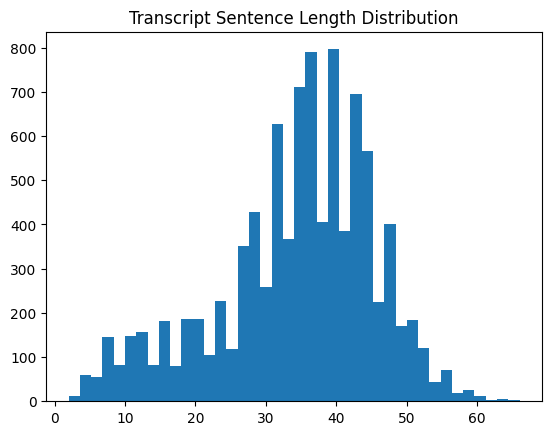

In [13]:
# Transcript EDA (text analysis : counts the number of words per sentence.)

text_files = []
for root, _, files in os.walk(DATASET_PATH_1):
    for f in files:
        if f.endswith(".txt"):
            text_files.append(os.path.join(root, f))

sent_lengths = []

for file in text_files[:200]:
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            text = " ".join(line.strip().split()[1:])
            sent_lengths.append(len(text.split()))

plt.hist(sent_lengths, bins=40)
plt.title("Transcript Sentence Length Distribution")
plt.show()

- The sentence lengths are approximately normally distributed, with a slight right skew.
- The mode (highest bar) is around 35-40 words.
- Most sentences fall between 10 and 55 words.
- There are very few sentences longer than 60 words.
- We should probably set our model's max_text_length to around 100 tokens. This will safely cover >99% of our data without excessive padding, optimizing memory usage.

In [14]:
# Speaker Distribution (counts the number of audio files per speaker)

speakers = [path.split(os.sep)[-3] for path in wav_files_train]
speaker_counts = pd.Series(speakers).value_counts()

speaker_counts.head(10)

,count
211,166
4014,165
730,161
2989,155
8063,155
4195,140
27,138
125,138
5339,137
118,137


- The top speakers (IDs 211, 4014, 730) all have roughly similar counts (arouns 160 files).
- The counts decrease slowly (166 down to 137 for the 10th speaker).
- The dataset is well-balanced. There is no "super-speaker" dominating the dataset, which prevents the model from overfitting to one specific voice or accent. Means that it is usable to create a generalized ASR system that recognizes phoneme.

## Test-Clean Data

In [15]:
# load test-clean data

DATASET_PATH_2 = "LibriSpeech_WAV/test-clean"

wav_files_test = []
for root, _, files in os.walk(DATASET_PATH_2):
    for f in files:
        if f.endswith(".wav"):
            wav_files_test.append(os.path.join(root, f))

print("Total wav files:", len(wav_files_test))

Total wav files: 2620


- The dataset size is small enough for fast validation, but still enough for a valid validation evaluation

In [16]:
# Basic Metadata EDA (sample rate, duration, size)
metadata = []

for path in tqdm(wav_files_test[:500]):
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    size_kb = os.path.getsize(path) / 1024

    metadata.append([path, sr, duration, size_kb])

df = pd.DataFrame(metadata, columns=["path", "sample_rate", "duration_sec", "size_kb"])
df.head(10)

100%|██████████| 500/500 [00:00<00:00, 1197.13it/s]


,path,sample_rate,duration_sec,size_kb
0,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,3.715,116.136719
1,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,1.980,61.917969
2,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,3.295,103.011719
3,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,2.705,84.574219
4,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,4.015,125.511719
5,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,6.990,218.480469
6,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,2.585,80.824219
7,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,3.575,111.761719
8,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,3.450,107.855469
9,LibriSpeech_WAV/test-clean/1580/141083/1580-14...,16000,4.515,141.136719


- The sample rate 16000 Hz is consistent in train and test dataset.
- The duration seems to vary

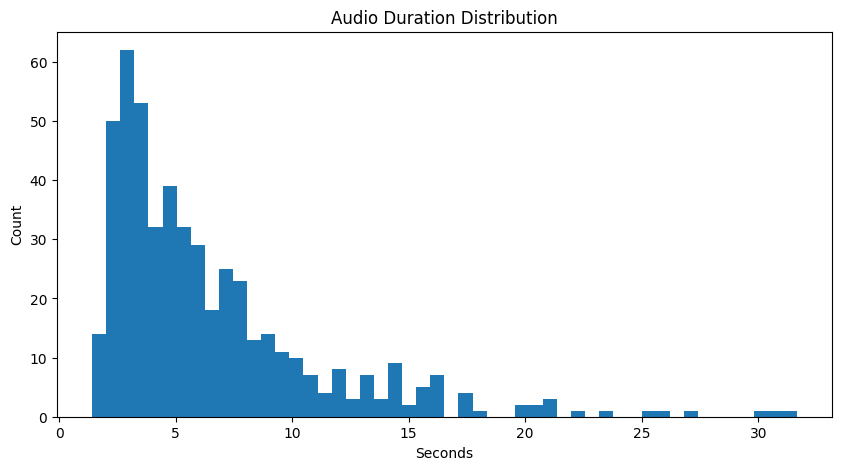

In [17]:
# Check duration distribution

plt.figure(figsize=(10,5))
plt.hist(df["duration_sec"], bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

- The test set duration distribution is right skewed, with the highest bar at around 3 seconds
- The x-axis extends all the way to 35 seconds

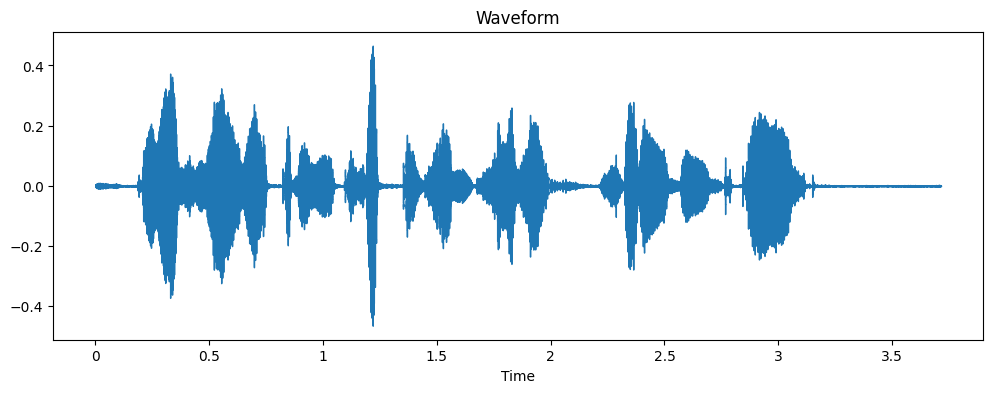

In [18]:
# Waveform Visualization (time domain)

sample_path = wav_files_test[0]
y, sr = librosa.load(sample_path, sr=None)

plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

- In the silence regions (start, end, and between words), the amplitude line is very thin and close to zero. This confirms the dataset is indeed "clean" speech with very little background noise. It has good Signal-To-Noise Ratio (SNR)
- The "blobs" of high amplitude represent words or phrases. There are distinct gaps between them, indicating clear sentence structures.

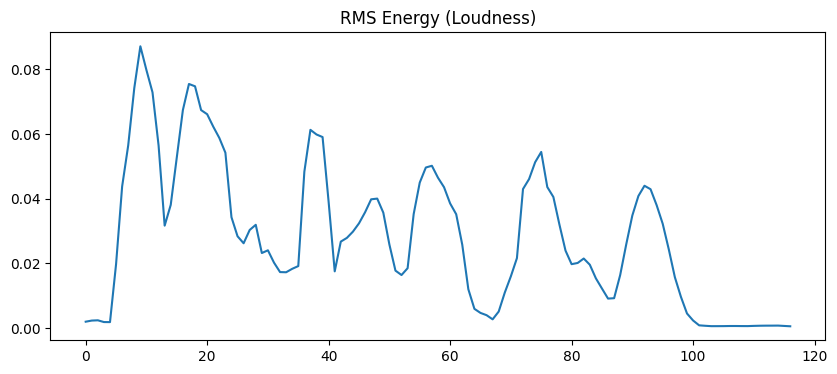

In [19]:
# Amplitude / Loudness (RMS)

rms = librosa.feature.rms(y=y)[0]

plt.figure(figsize=(10,4))
plt.plot(rms)
plt.title("RMS Energy (Loudness)")
plt.show()

- The plot clearly shows high energy peaks (active speech) and near-zero valleys (silence).
- The peaks vary in height, indicating natural speech dynamics (some words are stressed/louder than others).

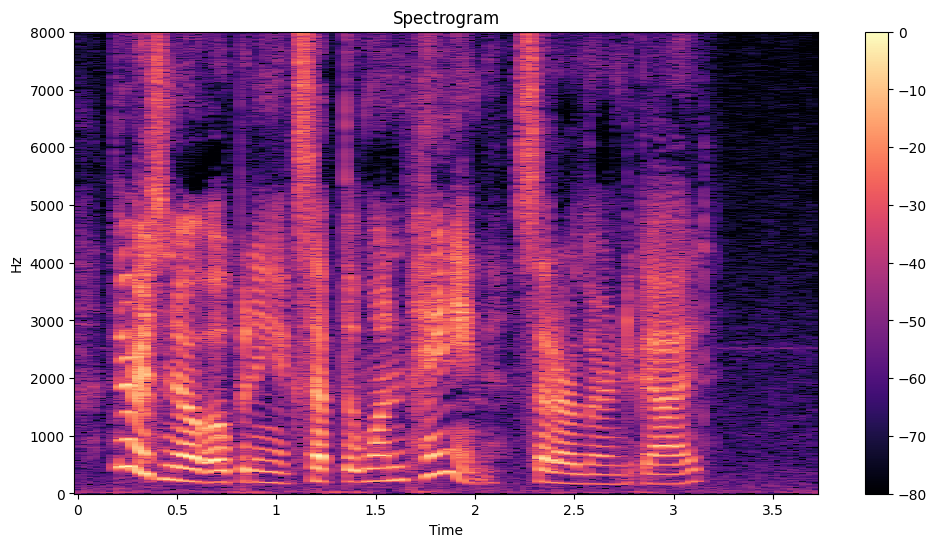

In [20]:
# Short-Time Fourier Transform (STFT) Spectogram
# To visualize signal frequency changes over time

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()

- The spectrogram shows clear harmonic structures below 3 kHz, indicating voiced speech segments dominated by vowels.
- Vertical broadband bursts correspond to consonant sounds, while darker regions represent short pauses.
- Overall, the recording quality appears clean with limited background noise.

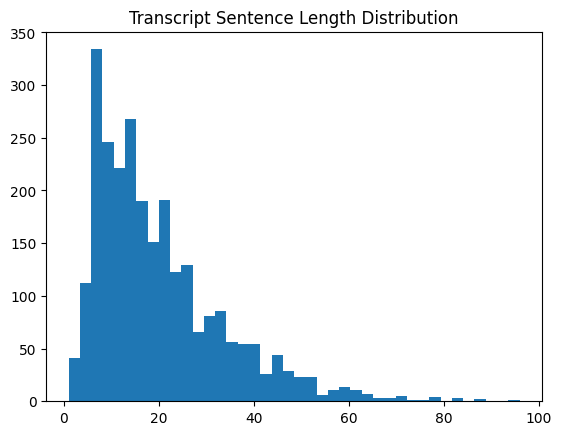

In [21]:
# Transcript EDA (text analysis : counts the number of words per sentence.)

text_files = []
for root, _, files in os.walk(DATASET_PATH_2):
    for f in files:
        if f.endswith(".txt"):
            text_files.append(os.path.join(root, f))

sent_lengths = []

for file in text_files[:200]:
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            text = " ".join(line.strip().split()[1:])
            sent_lengths.append(len(text.split()))

plt.hist(sent_lengths, bins=40)
plt.title("Transcript Sentence Length Distribution")
plt.show()

- The distribution is right-skewed, with most transcript sentences concentrated between roughly 5-25 words.
- There is a long tail extending toward longer sentences (up to 90-100 words), but these occur infrequently.
- This indicates the dataset is dominated by short-to-medium utterances, which is typical for conversational or read speech data.

100%|██████████| 200/200 [00:00<00:00, 1382.34it/s]


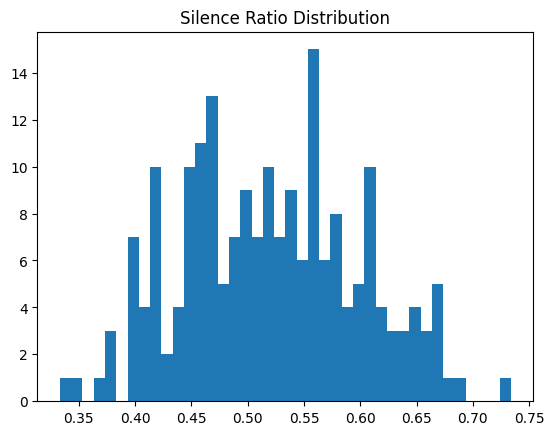

In [22]:
# Silence ratio

ratios_test = []
for path in tqdm(wav_files_test[:200]):
    y, sr = librosa.load(path, sr=None)
    ratios_test.append(silence_ratio(y))

plt.hist(ratios_test, bins=40)
plt.title("Silence Ratio Distribution")
plt.show()

- The curve is centered around 0.50 - 0.55 (50-55%).
- Which means more than half the recording contains silence.
- Since validating a model on 55% silence is inefficient. Maybe we can consider trimming (removing start/end silence) or filtering (dropping files that are >80% silence (the far right of the histogram), as they might be bad data).

In [23]:
speakers = [path.split(os.sep)[-3] for path in wav_files_test]
speaker_counts = pd.Series(speakers).value_counts()

speaker_counts.head(10)

,count
4446,108
1580,105
61,104
5142,102
6829,91
2830,90
237,88
260,82
6930,78
672,75


- The word count distribution across speakers in the validation set appears relatively balanced.
- No single speaker is overwhelmingly dominant, which helps reduce speaker bias in model evaluation.

In [24]:
# Check if there is any data leakage, whether each set is independent with no same speaker

def get_speakers(file_list):
    """
    Input is a list of file paths from librispeech
    Process is to extract speaker IDs from the file paths
    Output is a set of speaker IDs
    """
    speakers = set()
    for file_path in file_list:
        if isinstance(file_path, str):
            parts = file_path.split(os.sep)
            speaker_id = parts[-3]
            speakers.add(speaker_id)
    return speakers

train_spk = get_speakers(wav_files_train)
test_spk = get_speakers(wav_files_test)

leakage_train_test = train_spk.intersection(test_spk)

print(f"--- Speaker Counts ---")
print(f"Train Speakers: {len(train_spk)}")
print(f"Test Speakers:  {len(test_spk)}")

print(f"\n--- Leakage Report ---")

if len(leakage_train_test) > 0:
    print(f"[FAIL] Train-Test Leakage detected! ({len(leakage_train_test)} speakers)")
    print(f"Speakers: {leakage_train_test}")
else:
    print("[PASS] Train vs Test: Independent.")

--- Speaker Counts ---
Train Speakers: 251
Test Speakers:  40

--- Leakage Report ---
[PASS] Train vs Test: Independent.


- There is no data leakage between train and test data

The test data here, will be used as validation data for the model